# Setup

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_json("_RawData/train.json/data/processed/train.json")
test = pd.read_json("_RawData/test.json/data/processed/test.json")


In [5]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


In [7]:
train.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
train[train["inc_angle"] == 'na'].shape

(133, 5)

# Photo Samples

In [17]:
example_boat = train[train["is_iceberg"] == 0][:1]
example_iceberg = train[train["is_iceberg"] == 1][:1]

In [42]:
# fig = plt.figure(1, figsize=(15, 15))
boat_img = np.reshape(np.array(example_boat.iloc[0, 0]), (75, 75))
boat_img.shape

(75, 75)

In [50]:
icebergs = train[train.is_iceberg==1].sample(n=5,random_state=123)
ships = train[train.is_iceberg==0].sample(n=5,random_state=456)

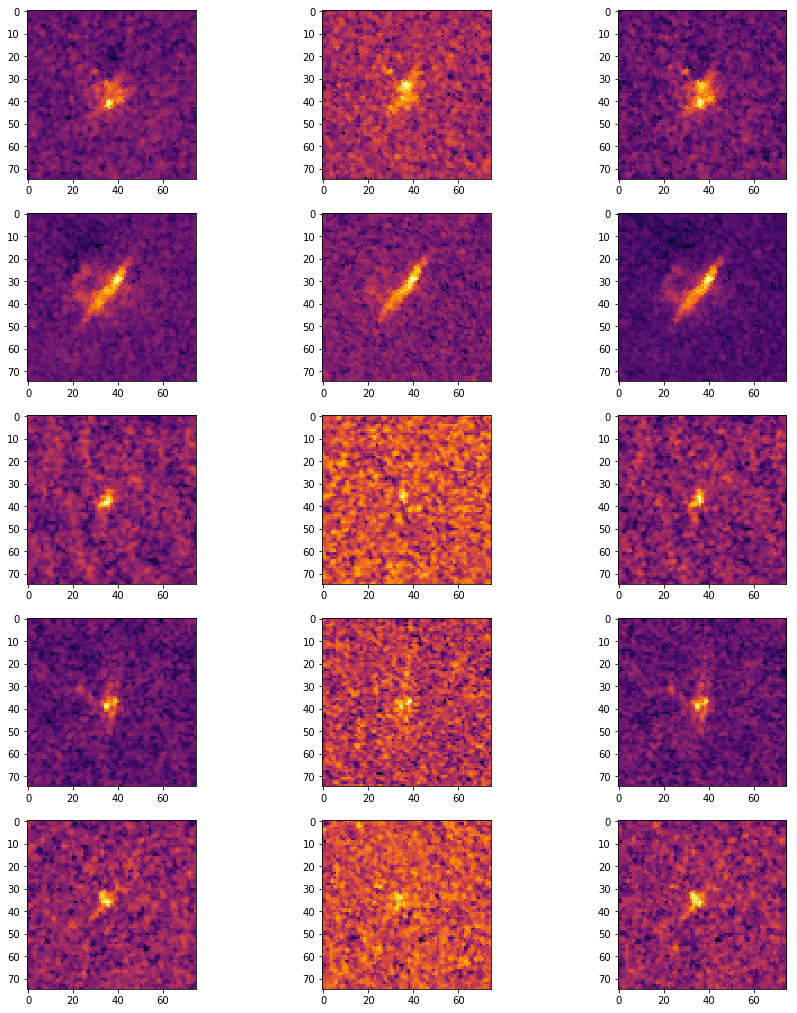

In [73]:
# Plot band_1
fig = plt.figure(1,figsize=(15,18))
for i in range(5):
    ax1 = fig.add_subplot(5, 3, i * 3 + 1)
    iceberg_band1 = np.reshape(np.array(icebergs.iloc[i,0]), (75, 75))
    ax2 = fig.add_subplot(5, 3, i * 3 + 2)
    iceberg_band2 = np.reshape(np.array(icebergs.iloc[i,1]), (75, 75))
    ax3 = fig.add_subplot(5, 3, i * 3 + 3)
    iceberg_combo = (iceberg_band1 + iceberg_band2) / 2.

    ax1.imshow(iceberg_band1, cmap='inferno')
    ax2.imshow(iceberg_band2, cmap='inferno')
    ax3.imshow(iceberg_combo, cmap='inferno')
     
plt.show()

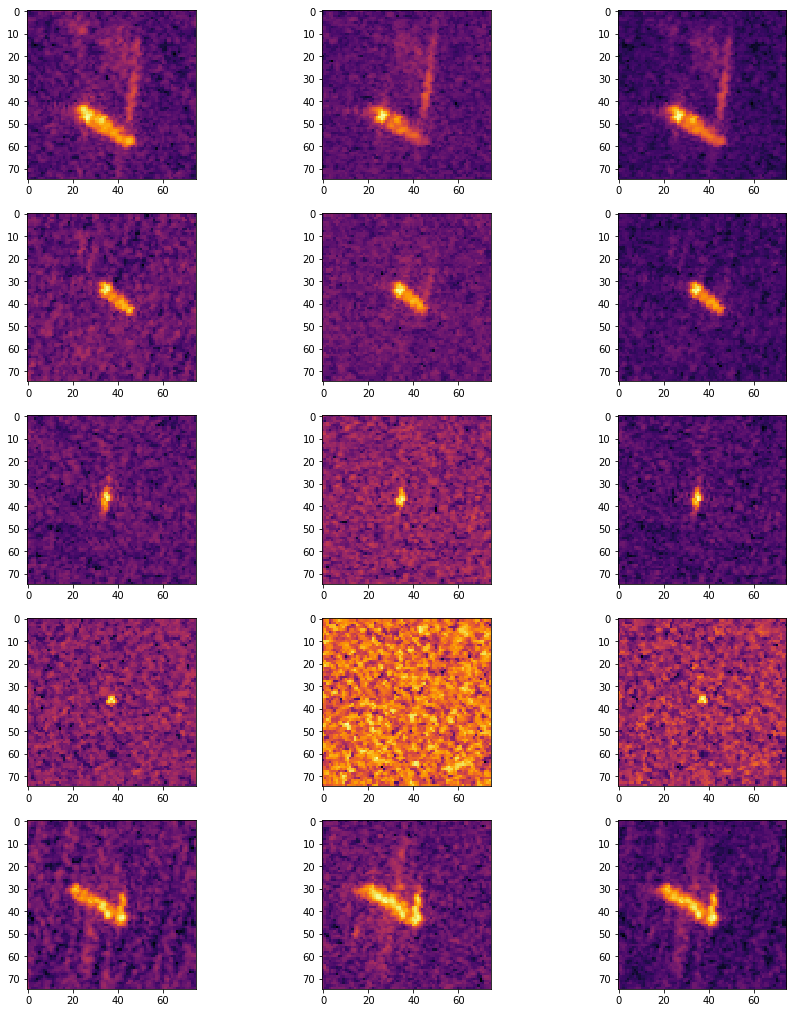

In [74]:
# Plot band_1
fig = plt.figure(1,figsize=(15,18))
for i in range(5):
    ax1 = fig.add_subplot(5, 3, i * 3 + 1)
    ships_band1 = np.reshape(np.array(ships.iloc[i,0]), (75, 75))
    ax2 = fig.add_subplot(5, 3, i * 3 + 2)
    ships_band2 = np.reshape(np.array(ships.iloc[i,1]), (75, 75))
    ax3 = fig.add_subplot(5, 3, i * 3 + 3)
    ships_combo = (ships_band1 + ships_band2) / 2.

    ax1.imshow(ships_band1, cmap='inferno')
    ax2.imshow(ships_band2, cmap='inferno')
    ax3.imshow(ships_combo, cmap='inferno')
     
plt.show()

# Basic CNN

In [76]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [77]:
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [115]:
# target_train=train['is_iceberg']
channel1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
channel2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
channel3 = (channel1 + channel2) / 2.


In [101]:
# X_train = np.concatenate([channel1[:, :, :, np.newaxis], channel2[:, :, :, np.newaxis],channel3[:, :, :, np.newaxis]], axis=-1)
# X_train = np.stack((channel1, channel2, channel3))

In [126]:
print(channel1.shape)
print(channel2.shape)
print(channel3.shape)


(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75)


(1604, 75, 75, 3)

In [137]:
# X_train = np.stack((channel1, channel2, channel3), axis = -1)
X_train = np.concatenate([channel1[:, :, :, np.newaxis], channel2[:, :, :, np.newaxis],channel3[:, :, :, np.newaxis]], axis=-1)

In [138]:
from sklearn.model_selection import train_test_split

target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train

In [139]:
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 128)       147584    
__________

# Testing Metrics

In [140]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

401/401 [==============================] - 0s     
Test loss: 0.279868995162
Test accuracy: 0.875311723671


In [171]:
predict = gmodel.predict(X_valid)

In [172]:
# predict_nice = [0.05 if predict < 0.05 else predict]

# x = 10 if a > b else 11

predict[predict < 0.025] = 0.025
predict[predict > 0.975] = 0.975

In [173]:
predict

array([[ 0.025     ],
       [ 0.025     ],
       [ 0.97500002],
       [ 0.025     ],
       [ 0.62125641],
       [ 0.12667681],
       [ 0.025     ],
       [ 0.90956759],
       [ 0.66517031],
       [ 0.62429231],
       [ 0.20973164],
       [ 0.025     ],
       [ 0.03664391],
       [ 0.96688819],
       [ 0.025     ],
       [ 0.025     ],
       [ 0.92946661],
       [ 0.025     ],
       [ 0.97500002],
       [ 0.96043903],
       [ 0.65171003],
       [ 0.38624707],
       [ 0.025     ],
       [ 0.97500002],
       [ 0.025     ],
       [ 0.025     ],
       [ 0.37730217],
       [ 0.97500002],
       [ 0.92690897],
       [ 0.025     ],
       [ 0.97500002],
       [ 0.97500002],
       [ 0.05439759],
       [ 0.94890374],
       [ 0.87127638],
       [ 0.025     ],
       [ 0.025     ],
       [ 0.025     ],
       [ 0.025     ],
       [ 0.025     ],
       [ 0.37082005],
       [ 0.80466771],
       [ 0.025     ],
       [ 0.72074258],
       [ 0.025     ],
       [ 0

In [174]:
print(predict.shape)
print(y_valid.values.reshape(-1, 1).shape)

(401, 1)
(401, 1)


In [177]:
from sklearn.metrics import classification_report, log_loss, accuracy_score

print(log_loss(y_valid.values.reshape(-1, 1), predict))
# print(accuracy_score(y_valid.values.reshape(-1, 1), predict))


0.285673186448


# Submission